# Lab 3: Homographies and Panoramas



In [2]:
#some magic to show the images inside the notebook
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import ndimage
import imageio as imio
import numpy as np
import subprocess
import sys
from IPython.display import clear_output


# A hepler function for displaying images within the notebook.
# It displays an image, optionally applies zoom the image.
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    

Populating the interactive namespace from numpy and matplotlib


## Task 1: Apply Homography (10 pts)

Write a function to apply a homography to an image into another. You will iterate over the output
image, and take image2 when possible, and image1 when the coordinates are outside image2.
Test your function on the provided bus.jpg and poster.jpg images using the homography: 

H=[[  8.34566914e-01  -3.12962592e-02  -4.53681006e+02],
   [  1.29611862e-01   1.21225212e+00  -5.04967813e+02],
   [ -8.20263106e-04   1.45634346e-05   1.00000000e+00]]

Remember you are using homogeneous coordinates.

For this you can use two methods, a loop iterating over the coordinates. Or use a meshgrid. Meshgrid is a useful tool to do domain transformations. You create two matrices with the values of the coordinates at each coordinate of the image. Then you can do operations on them, and use them as the indexes for sampling. Note that in the case of an homography, you might try to access coordinates outside the sampled image.

<img src="bus.jpg"  style="width: 350px;display: inline-block;"/>
<img src="poster.jpg"  style="width: 200px;display: inline-block;"/>
<img src="task1.png"  style="width: 350px;display: inline-block;"/>


100%


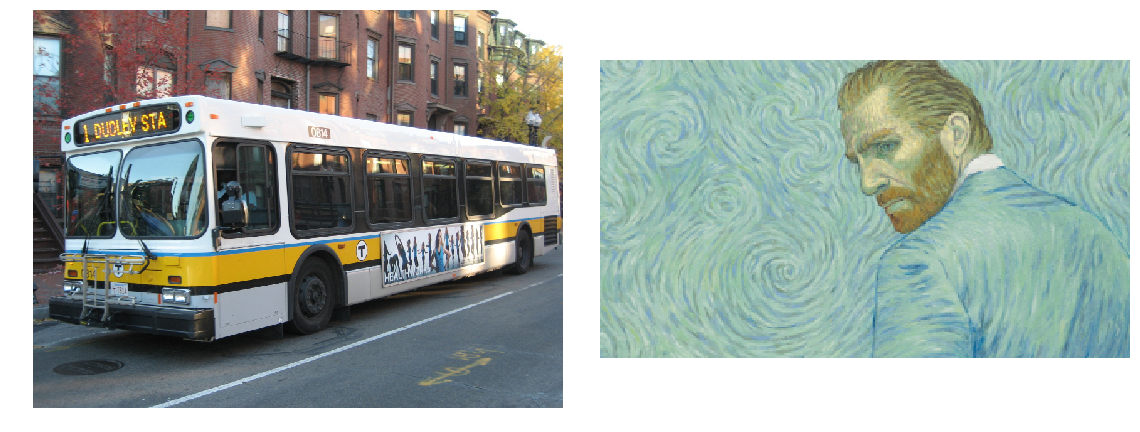

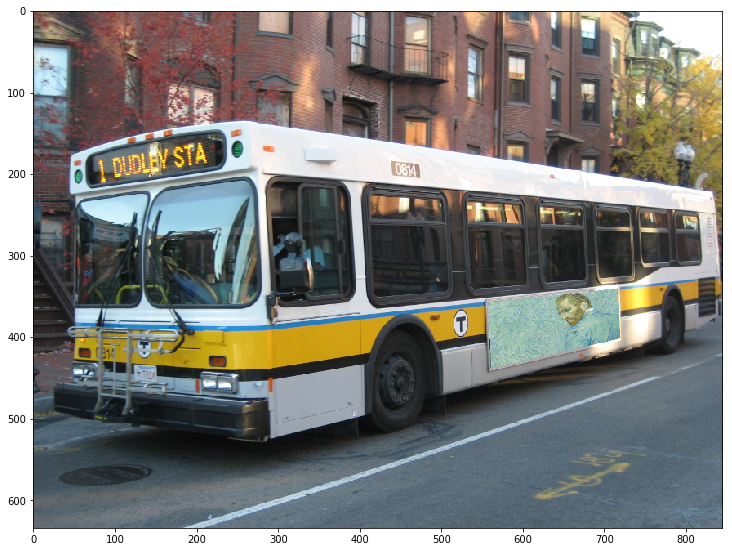

In [3]:
#homography to be applied
H = np.array([[  8.34566914e-01 , -3.12962592e-02 , -4.53681006e+02],
   [  1.29611862e-01   ,1.21225212 , -5.04967813e+02],
   [ -8.20263106e-04  , 1.45634346e-05  , 1.]])

#Examples of mesh grid
# A = np.array([[0.,1.],[1.,0.]])
#start, stop, components (stop & components are the resolution of the image) 
#or 1 and the resolution of the image if we use noormalized coordinates
# x = np.linspace(0, 1, 2) 
# y = np.linspace(0, 1, 2)
#meshgrid creates a matrix with the given linear spaces which will serve as 
#image coordinates with the same resolution as the image
# XY = np.meshgrid(x, y)
# print (XY)

# XX, YY = np.meshgrid(x, y)
# print (XX)
# print (YY)

#you can use this to index arrays (images)
# A[YY.astype(int),XX.astype(int)]

img2=(imio.imread("/home/michal/CmpPh/Lab3/poster.jpg"))
img1=(imio.imread("/home/michal/CmpPh/Lab3/bus.jpg"))
show_images([img1,img2])

def applyHomography(H,im1,im2):
#applies H to the coordinates of im1 to access im2
    for y in range(0,len(im1)):
        for x in range(0,len(im1[0])):
            y1=len(im1)-y
            p=np.array([x,y1,1.]).reshape(-1,1)
            p2=H.dot(p) 
            x2,y2=(int(p2[0]/p2[2]),int(p2[1]/p2[2]))
            
            if(x2>0 and y2>0):
                try:
                    im1[y1,x]=im2[y2,x2]
                except:
                    pass
        clear_output()
        sys.stdout.write(str(100*(y+2)/len(im1)))
        sys.stdout.write("%\n")
        sys.stdout.flush()
    return im1

show_image(applyHomography(H,img1,img2))


## Task 2: Bilinear Interpolation (10)

When sampling, the coordinates will be “between pixels”. Use bilinear interpolation to get a better
image. https://en.wikipedia.org/wiki/Bilinear_interpolation. Compare with nearest neighbour
sampling.

If you have used a loop, this is simple to add. 
If you used a meshgrid, this would be more tedious, but you can simply use ndimage.map_coordinates. Notice that you have other types of interpolations with higher order polynomia


100%


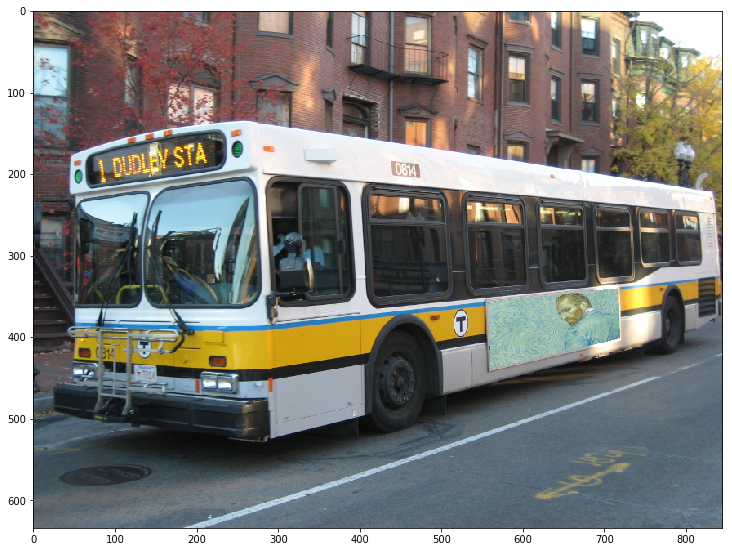

In [4]:
def applyHomographyInterpol(H,im1,im2):
#applies H to the coordinates of im1 to access im2
    for y in range(0,len(im1)):
        for x in range(0,len(im1[0])):
            y1=len(im1)-y
            p=np.array([x,y1,1.]).reshape(-1,1)
            p2=H.dot(p) 
            X,Y=(p2[0]/p2[2],p2[1]/p2[2])
            X1,Y1=(int(X),int(Y))
            X1,Y1=(int(X),int(Y))
            X2,Y2=(int(X)+1,int(Y)+1)
            
            if(X>0 and Y>0):
                try:
                    fR1=(X2-X)/(X2-X1)*im2[Y1,X1]+(X-X1)/(X2-X1)*im2[Y1,X2]
                    fR2=(X2-X)/(X2-X1)*im2[Y2,X1]+(X-X1)/(X2-X1)*im2[Y2,X2]
                    im1[y1,x]=(Y2-Y)/(Y2-Y1)*fR1+(Y-Y1)/(Y2-Y1)*fR2
                except:
                    pass
        clear_output()
        sys.stdout.write(str(100*(y+2)/len(im1)))
        sys.stdout.write("%\n")
        sys.stdout.flush()
    return im1
clear_output()
sys.stdout.write(str(100))
sys.stdout.write("%\n")
sys.stdout.flush()
show_image(applyHomographyInterpol(H,img1,img2))


## Task 3: Compute Homography from Points (30 pts)

Taking points correspondences from two images, compute the homography. You can do this with 4
points. The best solution is to set the system of equatoins from four correspondences and then solve it using SVD (least squares solution). Check homographies.pdf for more information.

Try also with this example

im1=imread(’pano/stata-1.png’)
im2=imread(’pano/stata-2.png’)
pointList1=[np.array([218, 209, 1]), np.array([300,425, 1]), np.array([337, 209, 1]), np.array([336, 396,
1])]
    pointList2=[np.array([4, 232, 1]), np.array([62, 465, 1]), np.array([125, 247, 1]), np.array([102, 433, 1])]
    
<img src="task3_stata.png"  style="width: 350px;display: inline-block;"/>


In [8]:
points1 = [np.array([557,357, 1]), np.array([716,340, 1]), np.array([560,437, 1]), np.array([718,401, 1])]
points2 = [np.array([0, 0, 1]), np.array([319, 0, 1]), np.array([0, 178, 1]), np.array([319, 178, 1])]

im1=imread('/home/michal/CmpPh/Lab3/data_pano/stata-1.png')
im2=imread('/home/michal/CmpPh/Lab3/data_pano/stata-2.png')
pointList1=[np.array([218, 209, 1]), np.array([300,425, 1]), np.array([337, 209, 1]), np.array([336, 396,1])]
pointList2=[np.array([4, 232, 1]), np.array([62, 465, 1]), np.array([125, 247, 1]), np.array([102, 433, 1])]
    

true_H = np.array([[  8.34566914e-01,  -3.12962592e-02,  -4.53681006e+02],
   [  1.29611862e-01,   1.21225212,  -5.04967813e+02],
   [ -8.20263106e-04,   1.45634346e-05,   1.]])


def find_homography(points1, points2):
    A = []
    #fill A with the equations from points1 and points2
    
    #solve A using SVD from in numpy.linalg
    #in numply SVD the matrix V is already transposed!    
    return H




## Task 4: Bounding Box (25 pts)

In the previous examples, you used the boundaries of the first image. For panorama stitching, we want to create a bigger image, as shown in the lecture examples. For this, we need to estimate the size of the output. You will need to compute the inverse of your Homography, and compute the coordinates for the corners. Then use an offset to translate between “outside of the image” coordinates and the new bigger image coordinates.

<img src="bbox.jpg"  style="width: 400px;display:inline-block;"/>
<img src="task4.png"  style="width: 400px;display:inline-block;"/>


## Task 5: Blending (25)

Implement and compare smooth and two bands blending. Compute the weights as the distance to
the boundary in the image, the center of the image should have value 1, and 0 at the boundaries.
Use this weights to mix both images, keeping track of the weights, so the sum of both images has
a value of one.

HINT: you can use linspace and meshgrid from task 1 to create hte weights. 

## Extra: Two band blending
For the two band blending, compute a gaussian blurred image and divide the original by this,
getting an image with the high frequencies only. Blend the blurred version with the same process
as before, and blend the high frequency by simply taking the pixel with the biggest weight. Then,
multiply both together to get the final image.

## Extra: Have fun!! 

There is quite a lot of images, try your code with them! Try on your own!

Use the tool Pano-UI to generate pairs of points. You can change the images in the click.html Share the list of points in skos if you have them :)